In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("titanic.csv")
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [3]:
def preprocess_data(df):
    df.drop(columns = ["PassengerId", "Name", "Ticket", "Cabin"], inplace = True)
    
    df["Embarked"] = df['Embarked'].fillna("S")
    df.drop(columns = ["Embarked"], inplace = True)

    fill_missing_values(df)
    
    #convert Gender from string to int
    df["Sex"] = df["Sex"].map({'male':1, 'female':0})

    # combine two columns into one
    df['FamilySize'] = df['SibSp'] + df['Parch']
    df['IsAlone'] = np.where(df['FamilySize'] == 0, 1, 0)
    df['FareBin'] = pd.qcut(df['Fare'], 4, labels = False)
    df['AgeBin'] = pd.cut(df['Age'], bins=[0,12,20,40,60, np.inf], labels=False)

    return df

def fill_missing_values(df):
    age_fill_map = {}
    for pclass in df["Pclass"].unique():
        if pclass not in age_fill_map:
            age_fill_map[pclass] = df[df["Pclass"] == pclass]["Age"].median()

    df["Age"] = df.apply(lambda row: age_fill_map[row["Pclass"]] if pd.isnull(row["Age"]) else row["Age"], axis = 1)

In [4]:
data = preprocess_data(data)
data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,FareBin,AgeBin
0,0,3,1,22.0,1,0,7.2500,1,0,0,2
1,1,1,0,38.0,1,0,71.2833,1,0,3,2
2,1,3,0,26.0,0,0,7.9250,0,1,1,2
3,1,1,0,35.0,1,0,53.1000,1,0,3,2
4,0,3,1,35.0,0,0,8.0500,0,1,1,2
5,0,3,1,24.0,0,0,8.4583,0,1,1,2
6,0,1,1,54.0,0,0,51.8625,0,1,3,3
7,0,3,1,2.0,3,1,21.0750,4,0,2,0
8,1,3,0,27.0,0,2,11.1333,2,0,1,2
9,1,2,0,14.0,1,0,30.0708,1,0,2,1


In [5]:
X = data.drop(columns = ["Survived"])
y = data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)


In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
def tune_model(X_train, y_train):
    param_grid = {
        "n_neighbors" : range(1,21),
        "metric" : ["euclidean", "manhattan", "minkowski"], 
        "weights" : ["uniform", "distance"]
    }

    model = KNeighborsClassifier()
    grid_search = GridSearchCV(model, param_grid, cv = 5, n_jobs = -1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

best_model = tune_model(X_train, y_train)

In [16]:
def evaluate_model(model, X_test, y_test):
    prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    matrix = confusion_matrix(y_test, prediction)

    return accuracy, matrix

accuracy, matrix = evaluate_model(best_model, X_test, y_test)

print(f"Accuracy: {accuracy*100:.2f}%")
print("Confusion Matrix:")
print(matrix)

Accuracy: 80.27%
Confusion Matrix:
[[115  19]
 [ 25  64]]


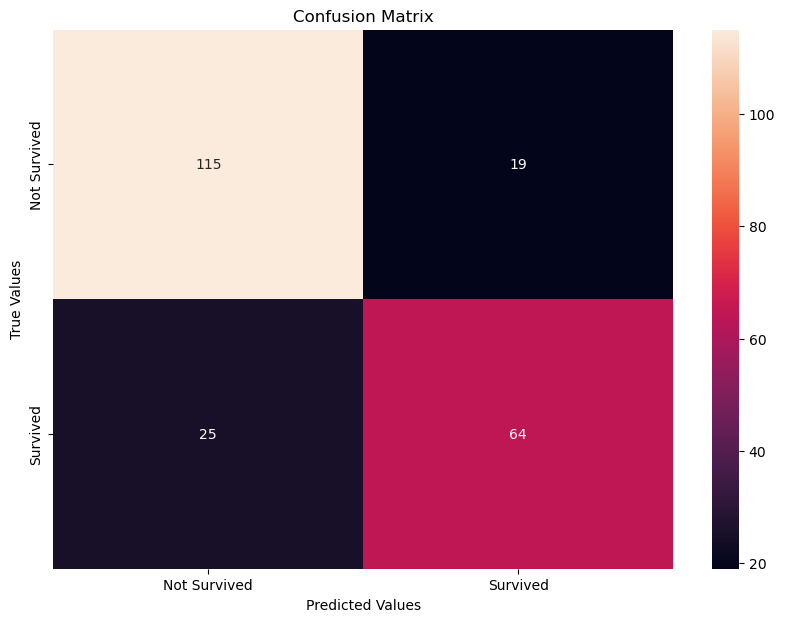

In [23]:
def plot_model(matrix):
    plt.figure(figsize = (10,7))
    sns.heatmap(matrix, annot = True, fmt = "d", xticklabels = ["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    plt.show()

plot_model(matrix)